In [157]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as sm
from sklearn import linear_model
%matplotlib inline

In [3]:
# Import data

path =r'D:\data_raw' # Please put all .csv documents into one folder
company_list = ['AAPL', 'AXP', 'BA', 'CAT', 'CSCO', 'CVX', 'DIS', 'DWDP', 'GE', 'GS', \
                           'HD', 'IBM', 'INTC', 'JNJ', 'JPM', 'KO', 'MCD', 'MMM', 'MRK', \
                            'MSFT', 'NKE', 'PFE', 'PG', 'TRV', 'UNH', 'UTX', 'V', 'VZ', 'WMT', 'XOM' ] # Input company name as a list
company_data = {} # Store company data as a dictionary: {company_name1: data1, company_name2: data2, ...}
for company in company_list:
    frame = pd.DataFrame()
    list_ = []
    allFiles = glob.glob(path + '/' +company + '*.csv')
    for file_ in allFiles:
        df = pd.read_csv(file_, index_col=None, header=0)
        list_.append(df)
    frame = pd.concat(list_)
    company_data[company] = frame

In [4]:
# Data cleaning

for company in company_data.keys():
    company_data[company].drop(company_data[company].columns[2:], axis = 1, inplace = True) # Keep only ''Time interval'  and 'Close' price
    company_data[company].drop(company_data[company][company_data[company]['Time Interval'] =='Summary'].index, axis = 0, inplace = True) # Delete Summary rows
    company_data[company]['Log_Price'] = np.log(company_data[company]['Close']) # Compute log price
    company_data[company]['Log_Return'] = company_data[company]['Log_Price'].diff() # Compute log return r
    company_data[company].dropna(axis = 0, how = 'any', inplace = True) # Drop lines with empty data

In [5]:
# Reshape data using 'Time Interval ' as columns

reshaped_data = {}
for company in company_data.keys():
    reshaped_data[company] = pd.DataFrame()
    group_by_5 = company_data[company].groupby(by = 'Time Interval') # Group data by 5 min time interval
    for i_5, i_5_data in group_by_5:
        reshaped_data[company][i_5] = pd.Series(list(i_5_data['Log_Return']))

In [6]:
# Compute daily return, RDVar, RDSkew and RDKurtosis

for com in reshaped_data.keys():
    N = reshaped_data[com].shape[1]
    reshaped_data[com]['DR'] = reshaped_data[com].apply(lambda x: np.sum(x[:N]), axis = 1)
    reshaped_data[com]['RDVar'] = reshaped_data[com].apply(lambda x: np.sum(np.square(x[:N])), axis = 1)
    reshaped_data[com]['RDSkew'] = reshaped_data[com].apply(lambda x: np.sqrt(N)*np.sum(np.power(x[:N], 3))/(x['RDVar']**1.5), axis = 1)
    reshaped_data[com]['RDKurtosis'] = reshaped_data[com].apply(lambda x: N*np.sum(np.power(x[:N], 4))/(x['RDVar']**2), axis = 1)

In [7]:
reshaped_data['AAPL'].head()

,09:35 - 09:40,09:40 - 09:45,09:45 - 09:50,09:50 - 09:55,09:55 - 10:00,10:00 - 10:05,10:05 - 10:10,10:10 - 10:15,10:15 - 10:20,10:20 - 10:25,...,15:30 - 15:35,15:35 - 15:40,15:40 - 15:45,15:45 - 15:50,15:50 - 15:55,15:55 - 16:00,DR,RDVar,RDSkew,RDKurtosis
0,0.002817,-0.000975,-0.001386,0.000716,0.001755,-0.000910,-0.000976,-0.000651,0.000651,-0.000195,...,0.000065,0.000716,0.000033,0.001008,-0.000143,-0.000377,0.002083,0.000049,-0.034297,5.451433
1,0.000970,-0.001746,0.001811,-0.002226,-0.000557,0.001554,-0.000906,-0.002075,0.001038,0.000583,...,0.000129,0.000259,0.000000,-0.000971,-0.000389,0.000777,-0.000647,0.000039,-0.493605,4.409002
2,-0.000521,-0.001434,0.000228,-0.000555,0.001988,-0.000287,-0.001278,0.000033,-0.000750,-0.000882,...,0.000033,0.000587,-0.000130,0.000847,-0.000723,0.000339,-0.000840,0.000033,0.197202,3.409307
3,-0.000310,0.001020,0.001547,0.000419,-0.002095,0.000581,0.000677,0.000387,-0.000161,-0.000354,...,0.000412,0.000425,-0.000257,-0.000097,-0.000322,0.000740,0.003287,0.000033,-0.399728,3.941852
4,-0.000387,-0.001677,-0.000194,-0.000588,-0.000123,0.001227,0.000452,-0.000129,-0.001065,0.001065,...,-0.000258,0.000355,0.000032,0.000387,0.000258,0.000644,0.000580,0.000024,-0.041219,3.185754


In [8]:
# Construct weekly data (5 trading days a week)
weekly_data = {}
for com in reshaped_data.keys():
    weekly_data[com] = pd.DataFrame()
    weekly_data[com]['WR'] = reshaped_data[com]['DR'].rolling(5).sum()[4::5]
    weekly_data[com]['RVol'] = np.sqrt(252.*reshaped_data[com]['RDVar'].rolling(5).mean()[4::5])
    weekly_data[com]['RSkew'] = reshaped_data[com]['RDSkew'].rolling(5).mean()[4::5]
    weekly_data[com]['RKurt'] = reshaped_data[com]['RDKurtosis'].rolling(5).mean()[4::5]

In [181]:
# Reset all the indices of dataframes to start from 0
for com in weekly_data.keys():
    weekly_data[com].index = pd.RangeIndex(len(weekly_data[com].index))

In [320]:
weekly_data['AAPL'].head()

,WR,RVol,RSkew,RKurt
0,0.004462,0.094435,-0.154330,4.079470
1,0.000635,0.097790,0.054424,5.149241
2,-0.001088,0.103214,-0.197347,5.088467
3,0.013911,0.118723,0.149588,3.637123
4,0.007153,0.187124,-0.121788,5.357063


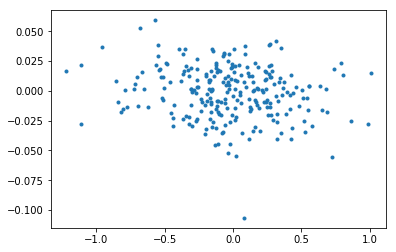

In [184]:
plt.plot(weekly_data['AAPL'].RSkew[:-1], weekly_data['AAPL'].WR[1:], '.')

In [185]:
weekly_data['AAPL'].head()

,WR,RVol,RSkew,RKurt
0,0.004462,0.094435,-0.154330,4.079470
1,0.000635,0.097790,0.054424,5.149241
2,-0.001088,0.103214,-0.197347,5.088467
3,0.013911,0.118723,0.149588,3.637123
4,0.007153,0.187124,-0.121788,5.357063


In [259]:
company_beta_pval = pd.DataFrame(columns = ['vol_intercept', 'b_vol', 'vol_p_val', 'skew_intercept', 'b_skew', \
                                                                                'skew_p_val','kurt_intercept','b_kurt', 'kurt_p_val'])
list_dict = []
x = np.arange(-5, 5)
for com in weekly_data.keys():
    data = pd.DataFrame({'r': np.array(weekly_data[com].WR[1:]), 'vol': np.array(weekly_data[com].RVol[:-1]), \
                                         'skew': np.array(weekly_data[com].RSkew[:-1]), 'kurt': np.array(weekly_data[com].RKurt[:-1])})
    lm_vol = sm.ols(formula = 'r ~ vol', data = data).fit()
    lm_skew = sm.ols(formula = 'r ~ skew', data = data).fit()
    lm_kurt = sm.ols(formula = 'r ~ kurt', data = data).fit()
    list_dict.append({'vol_intercept': lm_vol.params[0], 'b_vol': lm_vol.params[1], 'vol_p_val': lm_vol.pvalues[1], \
                                  'skew_intercept': lm_skew.params[0], 'b_skew': lm_skew.params[1], 'skew_p_val': lm_skew.pvalues[1],\
                                  'kurt_intercept': lm_kurt.params[0], 'b_kurt': lm_kurt.params[1], 'kurt_p_val': lm_kurt.pvalues[1]})
company_beta_pval = company_beta_pval.append(list_dict)

In [272]:
company_beta_pval.head()

,vol_intercept,b_vol,vol_p_val,skew_intercept,b_skew,skew_p_val,kurt_intercept,b_kurt,kurt_p_val
0,-0.008359,0.043174,0.073610,-0.001585,-0.008968,0.013861,-0.012115,0.002079,0.042323
1,-0.007488,0.047178,0.109505,-0.000789,-0.001543,0.625584,-0.001078,0.000045,0.954398
2,-0.002853,0.029535,0.190943,0.001762,0.000999,0.731363,0.001448,0.000060,0.936863
3,-0.004250,0.039293,0.101282,0.002494,-0.005689,0.104975,-0.003201,0.000992,0.312510
4,-0.006645,0.052215,0.064943,0.001371,-0.003988,0.276528,0.005268,-0.000824,0.417637


In [262]:
company_beta_pval.shape

(30, 9)

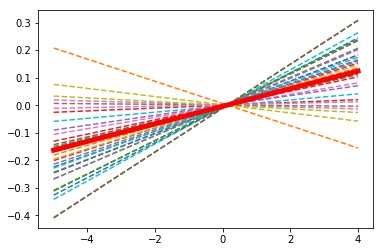

In [282]:
# Linear regression of return on vol
x = np.arange(-5,5)
for row in range(company_beta_pval.shape[0]):
    plt.plot(x, company_beta_pval.vol_intercept[row] + x*company_beta_pval.b_vol[row], '--')
plt.plot(x, company_beta_pval.vol_intercept.mean() + x*company_beta_pval.b_vol.mean(), color = 'red', lw = 5)
plt.show()

In [276]:
company_beta_pval.vol_intercept.mean()

-0.003693770680445719

(array([ 1.,  0.,  2.,  4.,  2.,  5.,  5.,  5.,  4.,  2.]),
 array([-0.04032412, -0.02831958, -0.01631505, -0.00431051,  0.00769402,
         0.01969856,  0.03170309,  0.04370763,  0.05571217,  0.0677167 ,
         0.07972124]),
 <a list of 10 Patch objects>)

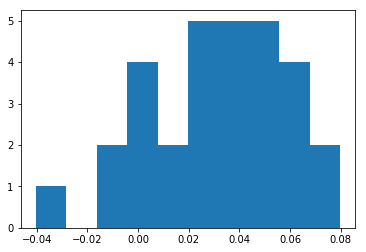

In [271]:
plt.hist(company_beta_pval.b_vol)

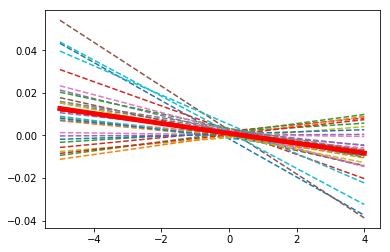

In [284]:
# Linear regression of return on skew
x = np.arange(-5,5)
for row in range(company_beta_pval.shape[0]):
    plt.plot(x, company_beta_pval.skew_intercept[row] + x*company_beta_pval.b_skew[row], '--')
plt.plot(x, company_beta_pval.skew_intercept.mean() + x*company_beta_pval.b_skew.mean(), color = 'red', lw = 5)
plt.show()

(array([  1.,   2.,   1.,   1.,   1.,   4.,  10.,   1.,   3.,   6.]),
 array([-0.01030983, -0.00905536, -0.00780089, -0.00654643, -0.00529196,
        -0.00403749, -0.00278303, -0.00152856, -0.00027409,  0.00098037,
         0.00223484]),
 <a list of 10 Patch objects>)

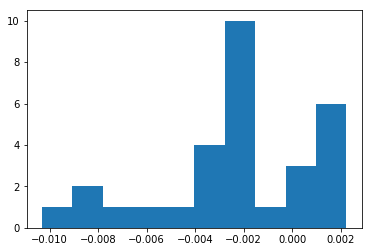

In [269]:
plt.hist(company_beta_pval.b_skew)

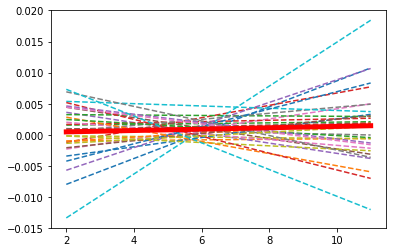

In [285]:
# Linear regression of return on kurt
x = np.arange(2, 12)
for row in range(company_beta_pval.shape[0]):
    plt.plot(x, company_beta_pval.kurt_intercept[row] + x*company_beta_pval.b_kurt[row], '--')
plt.plot(x, company_beta_pval.kurt_intercept.mean() + x*company_beta_pval.b_kurt.mean(), color = 'red', lw = 5)
plt.show()

(array([  1.,   2.,   6.,  10.,   4.,   3.,   2.,   1.,   0.,   1.]),
 array([-0.00214767, -0.00157995, -0.00101223, -0.0004445 ,  0.00012322,
         0.00069094,  0.00125866,  0.00182638,  0.0023941 ,  0.00296182,
         0.00352954]),
 <a list of 10 Patch objects>)

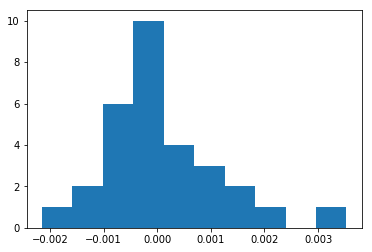

In [270]:
plt.hist(company_beta_pval.b_kurt)

In [292]:
weekly_data['AAPL'].head()

,WR,RVol,RSkew,RKurt
0,0.004462,0.094435,-0.154330,4.079470
1,0.000635,0.097790,0.054424,5.149241
2,-0.001088,0.103214,-0.197347,5.088467
3,0.013911,0.118723,0.149588,3.637123
4,0.007153,0.187124,-0.121788,5.357063


In [293]:
total_week = weekly_data['AAPL'].shape[0]

251

In [334]:
group_name = ['group1', 'group2', 'group3']
n_stock_grp = int(30/len(group_name))
return_by_group_skew = pd.DataFrame(columns = group_name)
tmp_list = []
for week in range(total_week-1):
    skew_this_week = sorted([(com, weekly_data[com].RSkew[week]) for com in weekly_data.keys()], key = lambda x: x[1])
    group_return_list = []
    for i in range(len(group_name)):
        cur_group = skew_this_week[n_stock_grp*i : n_stock_grp*i+n_stock_grp]
        sum_r = 0
        for com, _ in cur_group:
            sum_r += weekly_data[com].WR[week+1]
        group_return_list.append(sum_r/n_stock_grp)
    tmp_list.append(dict(zip(group_name, group_return_list)))
return_by_group_skew = return_by_group_skew.append(tmp_list)

In [336]:
n_stock_grp

10

In [337]:
return_by_group_skew.sum()

group1    0.376470
group2    0.214212
group3    0.129441
dtype: float64

In [338]:
return_by_group_skew.group1.index

Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            240, 241, 242, 243, 244, 245, 246, 247, 248, 249],
           dtype='int64', length=250)

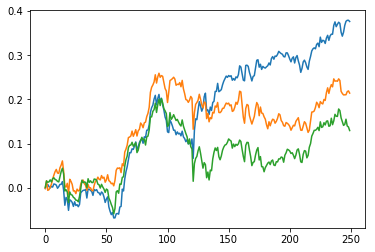

In [341]:
plt.plot(return_by_group_skew.group1.index, return_by_group_skew.group1.cumsum())
plt.plot(return_by_group_skew.group2.index, return_by_group_skew.group2.cumsum())
plt.plot(return_by_group_skew.group3.index, return_by_group_skew.group3.cumsum())